In [1]:
"""
Eisen ABC Challenge starter kit
NOTE: you need to register to the challenge, download and unpack the data in
order to be able to run the following example.
Find more info here: https://abcs.mgh.harvard.edu
This is released under MIT license. Do what you want with this code.
"""
from eisen.datasets import ABCsDataset
from eisen.models.segmentation import VNet
from eisen.io import LoadITKFromFilename
from eisen.transforms import (
    ResampleITKVolumes,
    ITKToNumpy,
    CropCenteredSubVolumes,
    AddChannelDimension,
    MapValues,
    FixedMeanStdNormalization,
    LabelMapToOneHot,
    StackImagesChannelwise,
    FilterFields
)
from eisen.ops.losses import DiceLoss
from eisen.ops.metrics import DiceMetric
from eisen.utils import EisenModuleWrapper
from eisen.utils.workflows import Training

from eisen.utils.logging import LoggingHook
from eisen.utils.logging import TensorboardSummaryHook
from eisen.utils.artifacts import SaveTorchModelHook

from torchvision.transforms import Compose
from torch.utils.data import DataLoader
from torch.optim import Adam

In [2]:
!pwd

/home/melihozaydin/Desktop/Fast-AI/MICCAI 2020 Challenge


In [3]:
# Defining some constants
PATH_DATA = 'Data/ABCs_training_data/'  # path of data as unpacked from the challenge files
PATH_ARTIFACTS = './results'  # path for model results

TASK = 'task1'

NUM_EPOCHS = 100
BATCH_SIZE = 1

VOLUMES_RESOLUTION = [2, 2, 1.5]
VOLUMES_PIXEL_SIZE = [128, 128, 128]

if TASK == 'task1':
    n_out_chan = 5
    label_field = 'label_task1'
else:
    n_out_chan = 10
    label_field = 'label_task2'
"""
Define Readers and Transforms
In order to load data and prepare it for being used by the network, we need to operate 
I/O operations and define transforms to standardize data.
You can add transforms or change the existing ones by editing this
"""

# readers: for images and labels
read_tform = LoadITKFromFilename(['ct', 't1', 't2', label_field], PATH_DATA)

# image manipulation transforms

resample_tform_img = ResampleITKVolumes(
    ['ct', 't1', 't2'],
    VOLUMES_RESOLUTION,
    'linear'
)

resample_tform_lbl = ResampleITKVolumes(
    [label_field],
    VOLUMES_RESOLUTION,
    'nearest'
)

to_numpy_tform = ITKToNumpy(['ct', 't1', 't2', label_field])

crop = CropCenteredSubVolumes(fields=['ct', 't1', 't2', label_field], size=VOLUMES_PIXEL_SIZE)

map_intensities = MapValues(['t1', 't2'], min_value=0.0, max_value=1.0)

normalize_ct = FixedMeanStdNormalization(['ct'], mean=208.0, std=388.0)

if TASK == 'task1':
    map_labels = LabelMapToOneHot([label_field], [1, 2, 3, 4, 5])
else:
    map_labels = LabelMapToOneHot([label_field], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

stack_modalities = StackImagesChannelwise(['ct', 't1', 't2'], 'image')

preserve_only_fields = FilterFields(['image', 'label_task1'])

# create a transform to manipulate and load data
tform = Compose([
    read_tform,
    resample_tform_img,
    resample_tform_lbl,
    to_numpy_tform,
    crop,
    map_intensities,
    normalize_ct,
    map_labels,
    stack_modalities,
    preserve_only_fields
])
# create a dataset from the training set of the ABC dataset
dataset = ABCsDataset(
    PATH_DATA,
    training=True,
    flat_dir_structure=True,  # check documentation
    transform=tform
)
data_loader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4
)

train_size = int(len(dataset)*0.8)
val_size = len(dataset) - train_size
train_size, val_size   

# Model Evaluation
https://discuss.pytorch.org/t/making-a-prediction-with-a-trained-model/2193

In [4]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
sample = next(iter(data_loader))

In [6]:
#sample-->dict
print(type(sample))
print(sample.keys())
print(sample['image'].shape)

<class 'dict'>
dict_keys(['image', 'label_task1'])
torch.Size([1, 3, 128, 128, 128])


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [8]:
x = sample['image'].to(device)
y_ = sample['label_task1']

# Model

In [9]:
# load saved model
model = EisenModuleWrapper(
    module=VNet(input_channels=3, output_channels=n_out_chan),
    input_names=['image'],
    output_names=['predictions']
)
checkpoint = torch.load('models/vnet0.877.pt')
model.load_state_dict(checkpoint)
model.eval()
model.to(device)


In [ ]:
!pip install torchsummary -q
from torchsummaryX import summary
summary(model, torch.zeros(3,128, 128, 128))

import gc
torch.cuda.empty_cache()
gc.collect()
print(torch.cuda.memory_summary())

In [15]:
pred = model(x)
out_tensor = pred['predictions']
pred.keys()

dict_keys(['predictions'])

In [106]:
print(f'input shape --> {x.shape} (batch, in_channel_modalities, x, y, z)' )
print(f'label mask shape --> {y_.shape}' )
print(f'output shape --> {out_tensor.shape} (batch, out_channel_labels, x, y, z)')

input shape --> torch.Size([1, 3, 128, 128, 128]) (batch, in_channel_modalities, x, y, z)
label mask shape --> torch.Size([1, 5, 128, 128, 128])
output shape --> torch.Size([1, 5, 128, 128, 128]) (batch, out_channel_labels, x, y, z)


# Visualize results

In [18]:
id = 30
x_sliced = x[0,0,id,:,:].cpu()
y = out_tensor[0,0,id,:,:].cpu().detach().numpy()
label = y_[0,0,id,:,:]

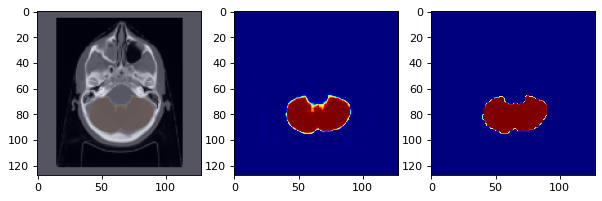

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')

ax[0].imshow(x_sliced, cmap='gist_gray')
ax[0].imshow(y, cmap='jet', alpha=0.1)
ax[1].imshow(y, cmap='jet', alpha=1)
ax[2].imshow(label, cmap='jet', alpha=1)

100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


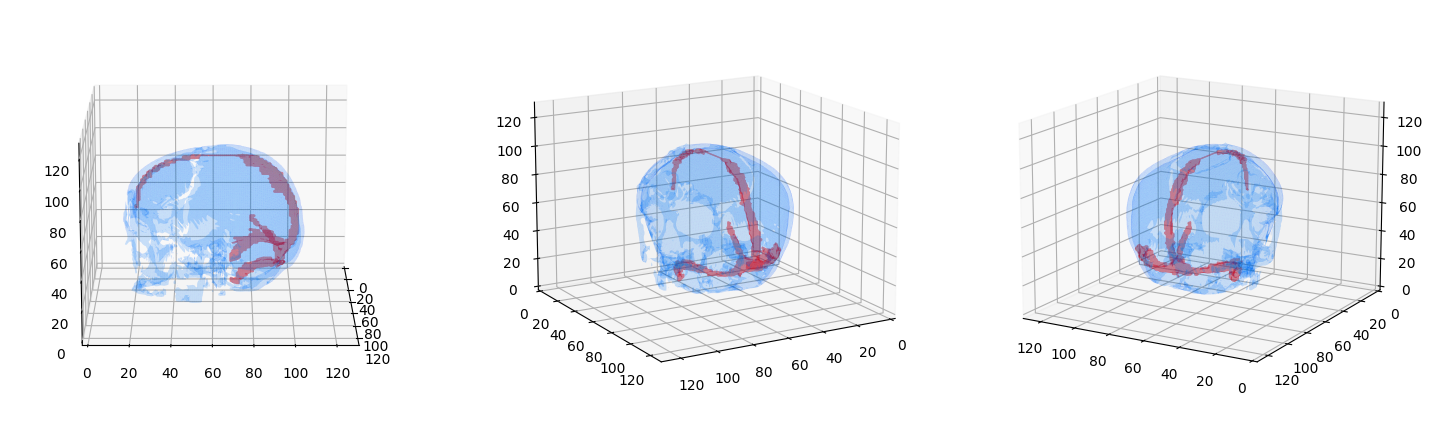

Took: 33.9867422580719 seconds


In [108]:
xp = x[0,0,:,:,:].cpu().numpy()
y_p = y_[0,2,:,:,:].numpy()


# make an input, label overlayed plot function
def plot_label_3d(x, y, views=3):
    from tqdm import tqdm
    import time
    st = time.time()
    fig, ax = plt.subplots(ncols=views, figsize=(18, 16), dpi=100, facecolor='w', edgecolor='k', subplot_kw={'projection': '3d'})
    
    if views == 1:
        ax = [ax]
        
    #fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
    #fig = plt.figure(figsize=(18, 16))
    #ax = fig.add_subplot(111, )
    
    x = x.transpose(2,1,0)
    y = y.transpose(2,1,0)
    threshold = 0
    x_face_color = [0, 0.5, 1] # Cyan
    y_face_color = [1, 0, 0] # Red    

    for i in tqdm(range(views)):
        
        ax[i].set_xlim(0, x.shape[0])
        ax[i].set_ylim(0, x.shape[1])
        ax[i].set_zlim(0, x.shape[2])
        
        verts, faces, normals, values = measure.marching_cubes(x)
        x_mesh = Poly3DCollection(verts[faces], alpha=0.1)
        verts, faces, normals, values = measure.marching_cubes(y)
        y_mesh = Poly3DCollection(verts[faces], alpha=0.3)
        x_mesh.set_facecolor(x_face_color)
        y_mesh.set_facecolor(y_face_color)
        
        ax[i].add_collection3d(x_mesh)
        ax[i].add_collection3d(y_mesh)
        ax[i].view_init(15, i*60)
        #ax[i].set_axis_bgcolor((0.7, 0.7, 0.7))
        
    plt.show()
    print(f'Took: {time.time()- st} seconds')


plot_label_3d(xp, y_p)

(128, 128, 128) (128, 128, 128)
[9.9198205e-11 1.2176735e-10 1.3420672e-10 ... 9.9998891e-01 9.9998915e-01
 9.9999213e-01]
y range 9.9198205e-11 0.99999213
x range -3.1741245 6.831791
y_ range 0.0 1.0


100%|██████████| 3/3 [00:03<00:00,  1.03s/it]


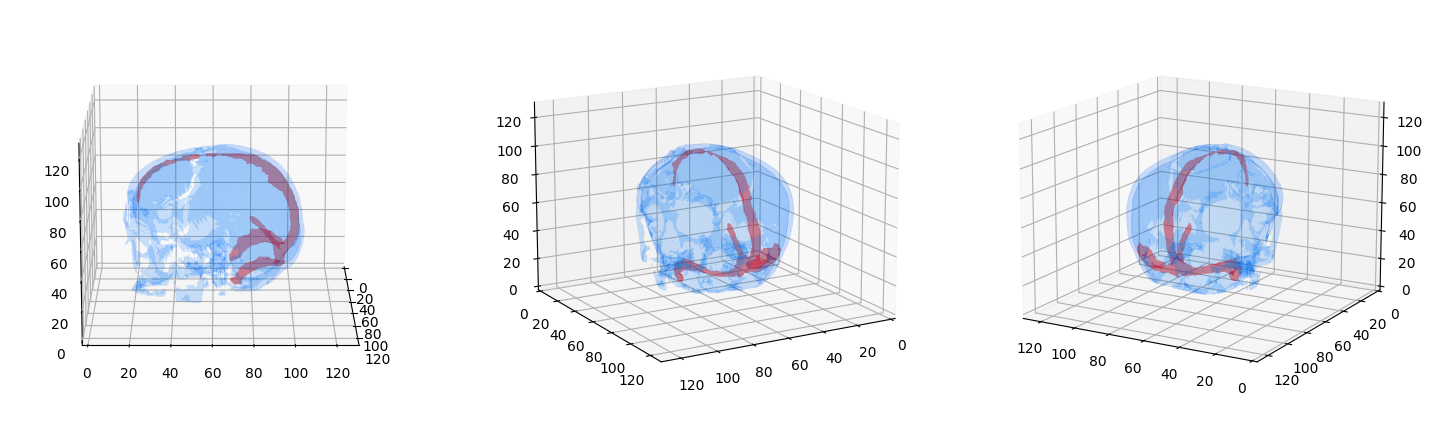

Took: 33.0404372215271 seconds


In [107]:
xp = x[0,0,:,:,:].cpu().numpy()
y = out_tensor[0,2,:,:,:].cpu().detach().numpy()
y_p = y_[0,0,:,:,:].numpy()

print(xp.shape ,y.shape)
print(np.unique(y))
print('y range', y.min(), y.max())
print('x range', xp.min(), xp.max())
print('y_ range', y_p.min(), y_p.max())

def norm(x):
    print('Old range:', x.min(), x.max())
    x = (x - x.min()) / (x.max()-x.min())
    print('New range:', x.min(), x.max())
    print(np.unique(x), x.shape)
    return x

plot_label_3d(xp, y)